In [ ]:
#!pip install opencv-python-headless

In [ ]:
import random
from copy import deepcopy
import cv2
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Experiment 1 - Uniform Crossover

### SSIM

* Run 1

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Run 1


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 139   2]
 [ 57  48  41]
 [170 170 170]
 [249 196 127]
 [232 226 212]
 [230 145  40]
 [161  97  18]
 [108 108 108]]
Generation 1, Best Fitness: 0.47062663165704943
Generation 2, Best Fitness: 0.47062663165704943
Generation 3, Best Fitness: 0.46106262200187953
Generation 4, Best Fitness: 0.45170870274477715
Generation 5, Best Fitness: 0.43262800589996986
Generation 6, Best Fitness: 0.43262800589996986
Generation 7, Best Fitness: 0.425989656830714
Generation 8, Best Fitness: 0.425989656830714
Generation 9, Best Fitness: 0.4186984578832301
Generation 10, Best Fitness: 0.41015133533513515
Generation 11, Best Fitness: 0.40836947971587356
Generation 12, Best Fitness: 0.40165151222915063
Generation 13, Best Fitness: 0.39945071528697873
Generation 14, Best Fitness: 0.39019539072505083
Generation 15, Best Fitness: 0.39019539072505083
Generation 16, Best Fitness: 0.38496062039800927
Generation 17, Best Fitness: 0.382864807172943
Generation 18

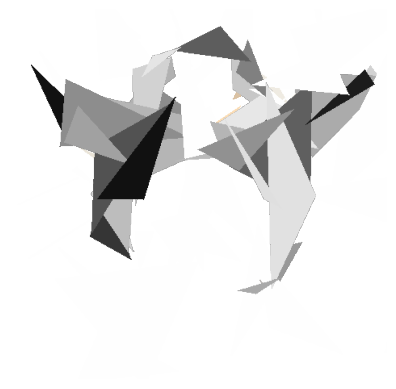

In [1]:
class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = self._random_color()

    def _random_color(self):
        return tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int)) + (random.randint(0, 256),)

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = self._random_color()
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('L'))
    rendered_image = np.array(painting.draw().convert('L'))
    ssim_value = ssim(target_array, rendered_image)
    return 1 - ssim_value

def uniform_crossover(parent1, parent2, crossover_prob=0.5):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)
    
    for i in range(len(parent1.triangles)):
        if random.random() < crossover_prob:
            child1.triangles[i], child2.triangles[i] = parent2.triangles[i], parent1.triangles[i]
    
    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = uniform_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

fitness_file = "fitness_values.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")



best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 2

Run 1


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Extracted palette: [[254 254 254]
 [ 46  33  23]
 [250 139   2]
 [180 180 180]
 [221 139  37]
 [ 77  75  72]
 [  0   0   0]
 [248 195 125]
 [236 231 215]
 [126 126 126]]
Generation 1, Best Fitness: 0.48438144730807886
Generation 2, Best Fitness: 0.47219018368419907
Generation 3, Best Fitness: 0.4708963860206171
Generation 4, Best Fitness: 0.47047007522341355
Generation 5, Best Fitness: 0.46230716829173424
Generation 6, Best Fitness: 0.4490491880692784
Generation 7, Best Fitness: 0.4362839111528509
Generation 8, Best Fitness: 0.43559455036668693
Generation 9, Best Fitness: 0.4280508539273221
Generation 10, Best Fitness: 0.41882466538867436
Generation 11, Best Fitness: 0.4082621341190915
Generation 12, Best Fitness: 0.4081674540474015
Generation 13, Best Fitness: 0.40288907249855754
Generation 14, Best Fitness: 0.396985372321323
Generation 15, Best Fitness: 0.3904581131457352
Generation 16, Best Fitness: 0.38365822456645027
Generation 17, Best Fitness: 0.377943185141017
Generation 18, Be

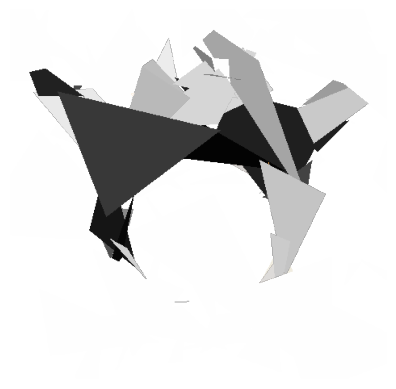

In [2]:
for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")


best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off') 
plt.show()

* Run 3

Run 1


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 139   2]
 [129 129 128]
 [ 78  76  73]
 [183 183 183]
 [248 195 125]
 [221 139  37]
 [238 233 216]
 [ 46  34  24]]
Generation 1, Best Fitness: 0.4830407147287412
Generation 2, Best Fitness: 0.48045097938284076
Generation 3, Best Fitness: 0.4664646747631366
Generation 4, Best Fitness: 0.4653339330126527
Generation 5, Best Fitness: 0.45485360676916375
Generation 6, Best Fitness: 0.444444478140947
Generation 7, Best Fitness: 0.444444478140947
Generation 8, Best Fitness: 0.43605589410140133
Generation 9, Best Fitness: 0.43605589410140133
Generation 10, Best Fitness: 0.4313428781973202
Generation 11, Best Fitness: 0.4207045234817818
Generation 12, Best Fitness: 0.4162071375429347
Generation 13, Best Fitness: 0.4140140880984019
Generation 14, Best Fitness: 0.411683380032146
Generation 15, Best Fitness: 0.4080594038424812
Generation 16, Best Fitness: 0.40430375330888846
Generation 17, Best Fitness: 0.39660100799626796
Generation 18, Best 

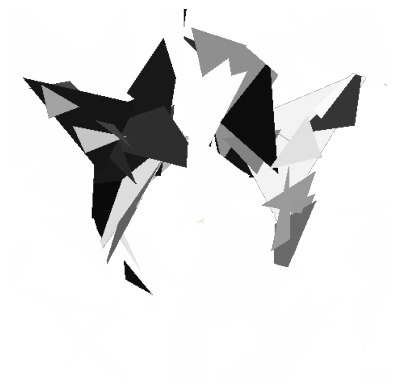

In [3]:
for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 4

Run 1


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 139   2]
 [131 131 130]
 [ 81  79  77]
 [240 234 218]
 [248 196 126]
 [185 185 185]
 [221 139  37]
 [ 48  36  25]]
Generation 1, Best Fitness: 0.47776333700360496
Generation 2, Best Fitness: 0.46610151883839834
Generation 3, Best Fitness: 0.4591930356072914
Generation 4, Best Fitness: 0.45786329515932367
Generation 5, Best Fitness: 0.4531623867020145
Generation 6, Best Fitness: 0.44178091242761264
Generation 7, Best Fitness: 0.4337930649104921
Generation 8, Best Fitness: 0.4294628198016871
Generation 9, Best Fitness: 0.4243270255271133
Generation 10, Best Fitness: 0.4205629435978425
Generation 11, Best Fitness: 0.41914868563735663
Generation 12, Best Fitness: 0.4110527102138266
Generation 13, Best Fitness: 0.40339291276972233
Generation 14, Best Fitness: 0.39993733378886487
Generation 15, Best Fitness: 0.39056326681620923
Generation 16, Best Fitness: 0.39056326681620923
Generation 17, Best Fitness: 0.38442434770356015
Generation 18

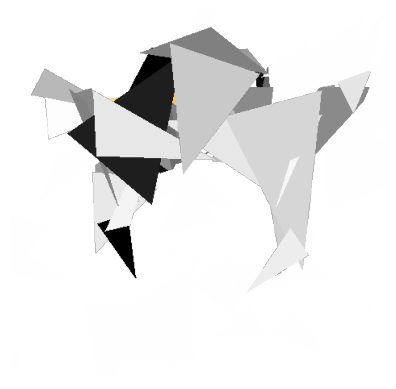

In [4]:
for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")


best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 5

Run 1


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 139   2]
 [ 81  79  77]
 [183 182 182]
 [ 49  36  26]
 [248 195 125]
 [238 232 216]
 [221 139  37]
 [130 130 130]]
Generation 1, Best Fitness: 0.4900100886998725
Generation 2, Best Fitness: 0.4848436376644858
Generation 3, Best Fitness: 0.4595178706177244
Generation 4, Best Fitness: 0.4595178706177244
Generation 5, Best Fitness: 0.4452572232731036
Generation 6, Best Fitness: 0.4452572232731036
Generation 7, Best Fitness: 0.4380939565234512
Generation 8, Best Fitness: 0.428344947379968
Generation 9, Best Fitness: 0.42351343024152566
Generation 10, Best Fitness: 0.4183974114183876
Generation 11, Best Fitness: 0.4181791189043498
Generation 12, Best Fitness: 0.40816231461289876
Generation 13, Best Fitness: 0.4080249457283056
Generation 14, Best Fitness: 0.4041863390882784
Generation 15, Best Fitness: 0.39684256220090175
Generation 16, Best Fitness: 0.39684256220090175
Generation 17, Best Fitness: 0.3886998664109075
Generation 18, Best 

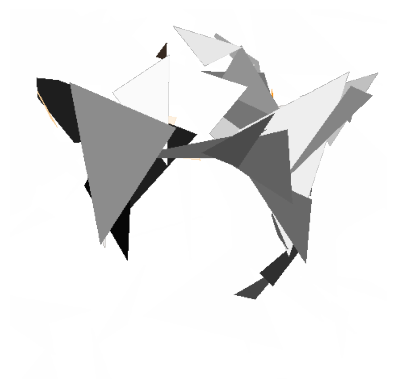

In [5]:
for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")


best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

## Plotting the mean fitness per generation

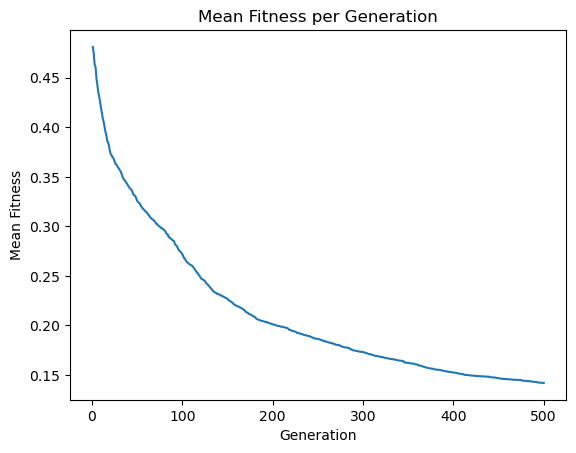

In [6]:
fitness_file = "fitness_values.txt"

with open(fitness_file, "r") as file:
    fitness_values = [float(line.strip()) for line in file]

num_generations_per_run = 500
num_runs = len(fitness_values) // num_generations_per_run

fitness_values = np.array(fitness_values)
fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)

mean_fitness_per_generation = np.mean(fitness_values, axis=0)

plt.plot(range(1, num_generations_per_run + 1), mean_fitness_per_generation)
plt.xlabel('Generation')
plt.ylabel('Mean Fitness')
plt.title('Mean Fitness per Generation')
plt.show()


## Euclidean distance

* Run 1

In [3]:
class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGB", (self._img_width, self._img_height), (255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image)
    rendered_image = np.array(painting.draw())
    # Calculate the Euclidean distance
    distance = np.sqrt(np.sum((target_array - rendered_image) ** 2))
    return distance

def two_point_crossover(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    point1 = random.randint(0, len(parent1.triangles) - 1)
    point2 = random.randint(point1, len(parent1.triangles))

    child1.triangles[point1:point2], child2.triangles[point1:point2] = parent2.triangles[point1:point2], parent1.triangles[point1:point2]

    return child1, child2

def uniform_crossover(parent1, parent2, crossover_prob=0.5):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    for i in range(len(parent1.triangles)):
        if random.random() < crossover_prob:
            child1.triangles[i], child2.triangles[i] = child2.triangles[i], child1.triangles[i]

    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = uniform_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

fitness_file = "fitness_values_euclidean_uniform.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")


Run 1
Extracted palette: [[223 123   0]
 [254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 82  82  82]
 [132 132 132]
 [119  66   0]
 [180 180 180]
 [ 39  35  29]
 [223 223 223]]
Generation 1, Best Fitness: 4619.153169142586
Generation 2, Best Fitness: 4443.742004212216
Generation 3, Best Fitness: 4342.520466273015
Generation 4, Best Fitness: 4309.518998681871
Generation 5, Best Fitness: 4178.272370250652
Generation 6, Best Fitness: 4075.673809322822
Generation 7, Best Fitness: 4074.9331282856656
Generation 8, Best Fitness: 4057.444515948431
Generation 9, Best Fitness: 4029.773939069039
Generation 10, Best Fitness: 3960.978793177262
Generation 11, Best Fitness: 3929.2235874279286
Generation 12, Best Fitness: 3915.055299737157
Generation 13, Best Fitness: 3899.7848658611924
Generation 14, Best Fitness: 3850.455167898985
Generation 15, Best Fitness: 3850.455167898985
Generation 16, Best Fitness: 3827.826276099792
Generation 17, Best Fitness: 3825.523232186677
Generation 18, Best Fitness: 38

Generation 169, Best Fitness: 2368.917263223855
Generation 170, Best Fitness: 2353.5322389973758
Generation 171, Best Fitness: 2353.5322389973758
Generation 172, Best Fitness: 2352.7628439772675
Generation 173, Best Fitness: 2324.3306563395836
Generation 174, Best Fitness: 2324.3306563395836
Generation 175, Best Fitness: 2322.7541841529423
Generation 176, Best Fitness: 2318.827936695606
Generation 177, Best Fitness: 2318.827936695606
Generation 178, Best Fitness: 2313.9777440589182
Generation 179, Best Fitness: 2313.9777440589182
Generation 180, Best Fitness: 2309.5545024960984
Generation 181, Best Fitness: 2279.799552592289
Generation 182, Best Fitness: 2278.5142088650664
Generation 183, Best Fitness: 2278.5142088650664
Generation 184, Best Fitness: 2270.5787808398104
Generation 185, Best Fitness: 2270.5787808398104
Generation 186, Best Fitness: 2269.375244423011
Generation 187, Best Fitness: 2191.055909829779
Generation 188, Best Fitness: 2191.055909829779
Generation 189, Best Fitnes

Generation 338, Best Fitness: 1774.1240091943966
Generation 339, Best Fitness: 1773.3569860577988
Generation 340, Best Fitness: 1771.9675504929542
Generation 341, Best Fitness: 1771.9675504929542
Generation 342, Best Fitness: 1770.7159568942727
Generation 343, Best Fitness: 1770.7159568942727
Generation 344, Best Fitness: 1769.670025739262
Generation 345, Best Fitness: 1769.670025739262
Generation 346, Best Fitness: 1769.436916083758
Generation 347, Best Fitness: 1769.301274514886
Generation 348, Best Fitness: 1768.0231898931643
Generation 349, Best Fitness: 1767.6532465390378
Generation 350, Best Fitness: 1767.6532465390378
Generation 351, Best Fitness: 1766.047564478375
Generation 352, Best Fitness: 1765.5064429222568
Generation 353, Best Fitness: 1764.066892155737
Generation 354, Best Fitness: 1763.7587703538145
Generation 355, Best Fitness: 1762.8028817766324
Generation 356, Best Fitness: 1762.8028817766324
Generation 357, Best Fitness: 1762.8028817766324
Generation 358, Best Fitne

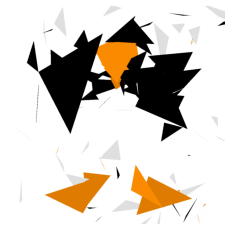

In [4]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 2

In [5]:
for run in range(1):
    print(f"Run {run + 2}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 2
Extracted palette: [[  0   0   0]
 [254 254 254]
 [250 138   0]
 [107 107 107]
 [123  68   0]
 [186 186 186]
 [ 36  30  23]
 [224 224 224]
 [ 69  69  69]
 [146 146 146]]
Generation 1, Best Fitness: 4791.759593301817
Generation 2, Best Fitness: 4768.9499892533995
Generation 3, Best Fitness: 4604.451867486509
Generation 4, Best Fitness: 4533.212326816382
Generation 5, Best Fitness: 4457.308604976774
Generation 6, Best Fitness: 4350.739477376231
Generation 7, Best Fitness: 4340.06854784576
Generation 8, Best Fitness: 4260.975592513996
Generation 9, Best Fitness: 4230.053545760385
Generation 10, Best Fitness: 4171.145166498045
Generation 11, Best Fitness: 4123.034925876811
Generation 12, Best Fitness: 4119.626560745524
Generation 13, Best Fitness: 4062.1862340370362
Generation 14, Best Fitness: 4018.370192005709
Generation 15, Best Fitness: 4017.5262289125135
Generation 16, Best Fitness: 3960.7037253498274
Generation 17, Best Fitness: 3921.102268495429
Generation 18, Best Fitness: 39

Generation 170, Best Fitness: 2903.039441688659
Generation 171, Best Fitness: 2901.5928384251297
Generation 172, Best Fitness: 2898.650893088024
Generation 173, Best Fitness: 2896.1489947860073
Generation 174, Best Fitness: 2893.809772600818
Generation 175, Best Fitness: 2891.5971365319892
Generation 176, Best Fitness: 2888.4687985159194
Generation 177, Best Fitness: 2888.4687985159194
Generation 178, Best Fitness: 2887.3962319016764
Generation 179, Best Fitness: 2886.76722303687
Generation 180, Best Fitness: 2883.400423111573
Generation 181, Best Fitness: 2879.5055131046374
Generation 182, Best Fitness: 2879.4148711153107
Generation 183, Best Fitness: 2878.5899325885234
Generation 184, Best Fitness: 2876.1312556974863
Generation 185, Best Fitness: 2871.5387860866513
Generation 186, Best Fitness: 2871.4175941510143
Generation 187, Best Fitness: 2869.765844106449
Generation 188, Best Fitness: 2865.6245392584146
Generation 189, Best Fitness: 2863.4418101299
Generation 190, Best Fitness: 

Generation 340, Best Fitness: 2027.0591999248566
Generation 341, Best Fitness: 2024.3463142456628
Generation 342, Best Fitness: 2023.0034602046533
Generation 343, Best Fitness: 2010.9251602185498
Generation 344, Best Fitness: 2010.4051830414685
Generation 345, Best Fitness: 2010.4051830414685
Generation 346, Best Fitness: 2001.6108512895307
Generation 347, Best Fitness: 2001.6108512895307
Generation 348, Best Fitness: 2000.0984975745569
Generation 349, Best Fitness: 2000.0984975745569
Generation 350, Best Fitness: 1995.488661957266
Generation 351, Best Fitness: 1993.6223313356018
Generation 352, Best Fitness: 1992.7194985747492
Generation 353, Best Fitness: 1992.7194985747492
Generation 354, Best Fitness: 1978.160509159962
Generation 355, Best Fitness: 1975.563717018512
Generation 356, Best Fitness: 1971.8600356009044
Generation 357, Best Fitness: 1969.4321516619962
Generation 358, Best Fitness: 1969.1320422968085
Generation 359, Best Fitness: 1967.3639724260481
Generation 360, Best Fi

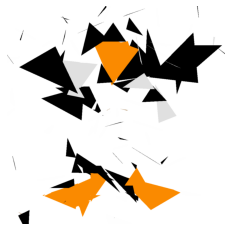

In [6]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 3

In [8]:
for run in range(1):
    print(f"Run {run + 3}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 3
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [107 107 107]
 [186 186 186]
 [123  68   0]
 [ 36  30  23]
 [224 224 224]
 [146 146 146]
 [ 69  69  69]]
Generation 1, Best Fitness: 4849.405942999617
Generation 2, Best Fitness: 4703.771678132347
Generation 3, Best Fitness: 4635.6216411609785
Generation 4, Best Fitness: 4529.835537853444
Generation 5, Best Fitness: 4495.78580450626
Generation 6, Best Fitness: 4393.36977728941
Generation 7, Best Fitness: 4368.359188528342
Generation 8, Best Fitness: 4283.914798405776
Generation 9, Best Fitness: 4283.914798405776
Generation 10, Best Fitness: 4217.856446110986
Generation 11, Best Fitness: 4217.856446110986
Generation 12, Best Fitness: 4199.551166493867
Generation 13, Best Fitness: 4150.617303486314
Generation 14, Best Fitness: 4128.0376694017705
Generation 15, Best Fitness: 4095.8201864828
Generation 16, Best Fitness: 4095.8201864828
Generation 17, Best Fitness: 4093.4092148232626
Generation 18, Best Fitness: 4074.740

Generation 169, Best Fitness: 2524.9231671478638
Generation 170, Best Fitness: 2520.501140646439
Generation 171, Best Fitness: 2520.2019760328735
Generation 172, Best Fitness: 2517.68524641187
Generation 173, Best Fitness: 2510.7124486886187
Generation 174, Best Fitness: 2510.182662676165
Generation 175, Best Fitness: 2507.8419009179984
Generation 176, Best Fitness: 2507.1116847878957
Generation 177, Best Fitness: 2502.5423073346833
Generation 178, Best Fitness: 2502.5423073346833
Generation 179, Best Fitness: 2497.2222568285747
Generation 180, Best Fitness: 2496.249586880286
Generation 181, Best Fitness: 2445.563125335349
Generation 182, Best Fitness: 2445.445358211874
Generation 183, Best Fitness: 2445.0128834016396
Generation 184, Best Fitness: 2440.621027525576
Generation 185, Best Fitness: 2440.621027525576
Generation 186, Best Fitness: 2439.137347506286
Generation 187, Best Fitness: 2438.8626447588226
Generation 188, Best Fitness: 2438.8626447588226
Generation 189, Best Fitness: 

Generation 338, Best Fitness: 2068.866839600848
Generation 339, Best Fitness: 2068.3541766341664
Generation 340, Best Fitness: 2065.8117048753497
Generation 341, Best Fitness: 2065.8117048753497
Generation 342, Best Fitness: 2065.7383667831705
Generation 343, Best Fitness: 2064.1228161134213
Generation 344, Best Fitness: 2062.59690681432
Generation 345, Best Fitness: 2061.1077118869844
Generation 346, Best Fitness: 2061.1077118869844
Generation 347, Best Fitness: 2061.1077118869844
Generation 348, Best Fitness: 2061.1077118869844
Generation 349, Best Fitness: 2060.785287214561
Generation 350, Best Fitness: 2058.7017753914724
Generation 351, Best Fitness: 2058.7017753914724
Generation 352, Best Fitness: 2056.4899707997606
Generation 353, Best Fitness: 2055.4802358573043
Generation 354, Best Fitness: 2054.766410081691
Generation 355, Best Fitness: 2052.0916158885307
Generation 356, Best Fitness: 2052.051412611292
Generation 357, Best Fitness: 2047.874019562727
Generation 358, Best Fitnes

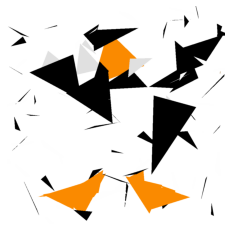

In [9]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 4

In [10]:
for run in range(1):
    print(f"Run {run + 4}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 4
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 86  86  86]
 [182 182 182]
 [119  66   0]
 [ 41  36  31]
 [223 223 223]
 [136 136 136]
 [223 123   0]]
Generation 1, Best Fitness: 4625.319124125383
Generation 2, Best Fitness: 4533.139640469947
Generation 3, Best Fitness: 4400.658473455989
Generation 4, Best Fitness: 4357.707080564273
Generation 5, Best Fitness: 4335.358578018662
Generation 6, Best Fitness: 4313.217012857109
Generation 7, Best Fitness: 4243.545569450151
Generation 8, Best Fitness: 4127.290515580409
Generation 9, Best Fitness: 4108.165649045813
Generation 10, Best Fitness: 4049.3501947843433
Generation 11, Best Fitness: 3983.0406726519877
Generation 12, Best Fitness: 3923.573626172956
Generation 13, Best Fitness: 3886.904295194313
Generation 14, Best Fitness: 3809.632790703062
Generation 15, Best Fitness: 3799.966052479943
Generation 16, Best Fitness: 3799.966052479943
Generation 17, Best Fitness: 3741.450520854178
Generation 18, Best Fitness: 374

Generation 169, Best Fitness: 2210.4400014476755
Generation 170, Best Fitness: 2208.9035741743005
Generation 171, Best Fitness: 2208.7100307645637
Generation 172, Best Fitness: 2206.1985404763554
Generation 173, Best Fitness: 2191.497889572335
Generation 174, Best Fitness: 2188.902921556824
Generation 175, Best Fitness: 2188.902921556824
Generation 176, Best Fitness: 2185.686391045156
Generation 177, Best Fitness: 2185.3775417533693
Generation 178, Best Fitness: 2182.482531430664
Generation 179, Best Fitness: 2182.482531430664
Generation 180, Best Fitness: 2182.482531430664
Generation 181, Best Fitness: 2180.97019695364
Generation 182, Best Fitness: 2179.7463155147207
Generation 183, Best Fitness: 2179.264325408921
Generation 184, Best Fitness: 2178.063819083362
Generation 185, Best Fitness: 2171.4626407101737
Generation 186, Best Fitness: 2169.850916537816
Generation 187, Best Fitness: 2168.647735341081
Generation 188, Best Fitness: 2163.2607332450707
Generation 189, Best Fitness: 215

Generation 338, Best Fitness: 1789.6281736718386
Generation 339, Best Fitness: 1789.6281736718386
Generation 340, Best Fitness: 1789.5049594790175
Generation 341, Best Fitness: 1787.8744363069795
Generation 342, Best Fitness: 1784.8697431465412
Generation 343, Best Fitness: 1784.180484143911
Generation 344, Best Fitness: 1783.954315558557
Generation 345, Best Fitness: 1783.7749297487057
Generation 346, Best Fitness: 1783.351059101937
Generation 347, Best Fitness: 1782.5804329678926
Generation 348, Best Fitness: 1782.3661240048298
Generation 349, Best Fitness: 1782.0855759474628
Generation 350, Best Fitness: 1781.7174298973448
Generation 351, Best Fitness: 1781.4769153710638
Generation 352, Best Fitness: 1781.4095542575267
Generation 353, Best Fitness: 1771.7310744015301
Generation 354, Best Fitness: 1771.7310744015301
Generation 355, Best Fitness: 1770.7436291004974
Generation 356, Best Fitness: 1770.7436291004974
Generation 357, Best Fitness: 1769.7330307139548
Generation 358, Best Fi

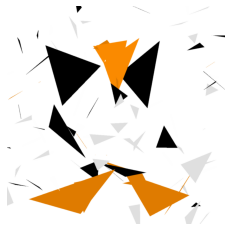

In [11]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 5

In [12]:
for run in range(1):
    print(f"Run {run + 5}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 5
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [146 146 146]
 [123  68   0]
 [186 186 186]
 [ 68  68  68]
 [106 106 106]
 [224 224 224]
 [ 34  29  22]]
Generation 1, Best Fitness: 5078.772686387923
Generation 2, Best Fitness: 4999.191934703048
Generation 3, Best Fitness: 4977.045609596119
Generation 4, Best Fitness: 4740.798350489082
Generation 5, Best Fitness: 4740.798350489082
Generation 6, Best Fitness: 4608.355889034613
Generation 7, Best Fitness: 4594.405075741581
Generation 8, Best Fitness: 4530.543124173966
Generation 9, Best Fitness: 4487.572617796842
Generation 10, Best Fitness: 4485.390172549095
Generation 11, Best Fitness: 4396.9512164680655
Generation 12, Best Fitness: 4389.972665062962
Generation 13, Best Fitness: 4327.056274189186
Generation 14, Best Fitness: 4281.3411450151925
Generation 15, Best Fitness: 4247.203079674905
Generation 16, Best Fitness: 4214.471615754459
Generation 17, Best Fitness: 4205.042687060382
Generation 18, Best Fitness: 415

Generation 169, Best Fitness: 2828.6378347183295
Generation 170, Best Fitness: 2810.804689052585
Generation 171, Best Fitness: 2809.5108115114986
Generation 172, Best Fitness: 2804.6251086375164
Generation 173, Best Fitness: 2799.284194218229
Generation 174, Best Fitness: 2791.5096274238426
Generation 175, Best Fitness: 2785.4462838116265
Generation 176, Best Fitness: 2785.4462838116265
Generation 177, Best Fitness: 2754.862247009821
Generation 178, Best Fitness: 2754.862247009821
Generation 179, Best Fitness: 2740.4227776020252
Generation 180, Best Fitness: 2740.4227776020252
Generation 181, Best Fitness: 2734.373237142289
Generation 182, Best Fitness: 2734.373237142289
Generation 183, Best Fitness: 2733.3300203231956
Generation 184, Best Fitness: 2733.3300203231956
Generation 185, Best Fitness: 2732.9882912299495
Generation 186, Best Fitness: 2730.196879347715
Generation 187, Best Fitness: 2730.196879347715
Generation 188, Best Fitness: 2729.9254568577508
Generation 189, Best Fitness

Generation 338, Best Fitness: 2074.4833091639953
Generation 339, Best Fitness: 2074.4833091639953
Generation 340, Best Fitness: 2059.7511985674387
Generation 341, Best Fitness: 2055.0209244676803
Generation 342, Best Fitness: 2053.9486361640106
Generation 343, Best Fitness: 2008.2464988143263
Generation 344, Best Fitness: 2008.2464988143263
Generation 345, Best Fitness: 2004.976059707447
Generation 346, Best Fitness: 1996.7243174760006
Generation 347, Best Fitness: 1996.7243174760006
Generation 348, Best Fitness: 1990.2469695995017
Generation 349, Best Fitness: 1989.50119376692
Generation 350, Best Fitness: 1983.147498296584
Generation 351, Best Fitness: 1983.059757042132
Generation 352, Best Fitness: 1980.6203573628138
Generation 353, Best Fitness: 1977.4620097488598
Generation 354, Best Fitness: 1977.303466845694
Generation 355, Best Fitness: 1974.6619963933067
Generation 356, Best Fitness: 1974.6619963933067
Generation 357, Best Fitness: 1974.5556462151173
Generation 358, Best Fitne

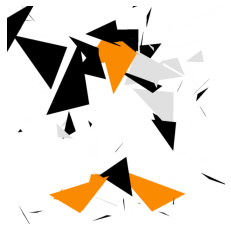

In [13]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

## Plotting mean fitness per generation

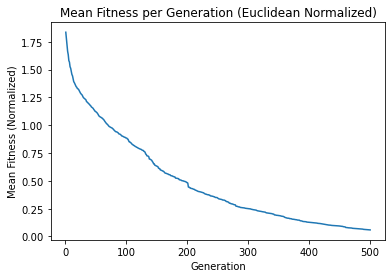

In [14]:
fitness_file = "fitness_values_euclidean_uniform.txt"

with open(fitness_file, "r") as file:
    fitness_values = [float(line.strip()) for line in file]

num_generations_per_run = 500
num_runs = len(fitness_values) // num_generations_per_run

fitness_values = np.array(fitness_values)
fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)

min_value = np.min(fitness_values)
max_value = np.max(fitness_values)
normalized_fitness_values = 2 * (fitness_values - min_value) / (max_value - min_value)

mean_fitness_per_generation = np.mean(normalized_fitness_values, axis=0)

plt.plot(range(1, num_generations_per_run + 1), mean_fitness_per_generation)
plt.xlabel('Generation')
plt.ylabel('Mean Fitness (Normalized)')
plt.title('Mean Fitness per Generation (Euclidean Normalized)')
plt.show()

# Comparisson between SSIM and Euclidean 

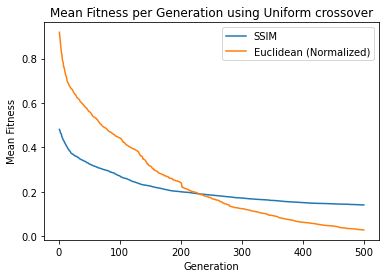

In [16]:
def process_fitness_file(filename, normalize=False):
    with open(filename, "r") as file:
        fitness_values = [float(line.strip()) for line in file]

    num_generations_per_run = 500
    num_runs = len(fitness_values) // num_generations_per_run

    fitness_values = np.array(fitness_values)
    fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)

    if normalize:
        min_value = np.min(fitness_values)
        max_value = np.max(fitness_values)
        fitness_values = (fitness_values - min_value) / (max_value - min_value)
    
    mean_fitness_per_generation = np.mean(fitness_values, axis=0)
    
    return mean_fitness_per_generation

mean_fitness_2PC = process_fitness_file("fitness_values_uniform.txt")
mean_fitness_euclidean = process_fitness_file("fitness_values_euclidean_uniform.txt", normalize=True)

plt.plot(range(1, 501), mean_fitness_2PC, label='SSIM')
plt.plot(range(1, 501), mean_fitness_euclidean, label='Euclidean (Normalized)')
plt.xlabel('Generation')
plt.ylabel('Mean Fitness')
plt.title('Mean Fitness per Generation using Uniform crossover')
plt.legend()
plt.show()
